In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

from utils import *

In [6]:
data_folder =  'csv_data/'
suffix = ''

df_public = pd.read_csv(data_folder + 'df_public_test' + suffix +'.csv', index_col='Unnamed: 0')
df_private = pd.read_csv(data_folder + 'df_private_test' + suffix +'.csv', index_col='Unnamed: 0')
df_ER = pd.read_csv(data_folder + 'df_ER' + suffix +'.csv', index_col='Unnamed: 0')
df_NR = pd.read_csv(data_folder + 'df_NR' + suffix +'.csv', index_col='Unnamed: 0')

df_NR['abs_dmu_x'] = np.abs(df_NR['mu_x'] - 288)
df_NR['abs_dmu_y'] = np.abs(df_NR['mu_y'] - 288)

df_ER['abs_dmu_x'] = np.abs(df_ER['mu_x'] - 288)
df_ER['abs_dmu_y'] = np.abs(df_ER['mu_y'] - 288)

df_public['abs_dmu_x'] = np.abs(df_public['mu_x'] - 288)
df_public['abs_dmu_y'] = np.abs(df_public['mu_y'] - 288)

df_private['abs_dmu_x'] = np.abs(df_private['mu_x'] - 288)
df_private['abs_dmu_y'] = np.abs(df_private['mu_y'] - 288)

df = pd.concat([df_NR, df_ER])

feat_list = [df_ER.columns[i] for i in range(len(df_ER.columns)) if df_ER.columns[i][-11:-1] != 'bkgr_only_']
feat_list_bkgr = [df_ER.columns[i] for i in range(len(df_ER.columns)) if df_ER.columns[i][-11:-1] == 'bkgr_only_']

## Solution that works well on public (score 815), but is expected to fall on private:

In [7]:
feat_list_train = list(set(feat_list) - set(['event_ID', 'event_angle', 'event_class', 'event_energy', 'image_name']))
feat_list_train += feat_list_bkgr

#### regression

In [8]:
sc = cross_validate(tree.DecisionTreeRegressor(max_depth=50, criterion="mse"), df[feat_list_train].values, df['event_energy'].values, scoring='neg_mean_absolute_error', cv=5)
print('best model score:' + '{:.4f} +- {:.4f}'.format(np.mean(sc['test_score']), np.std(sc['test_score'])))

best model score:-0.2377 +- 0.0522


In [9]:
reg = tree.DecisionTreeRegressor(max_depth=50, criterion="mse").fit(df[feat_list_train].values, df['event_energy'].values)
reg_pred_publ = reg.predict(df_public[feat_list_train].values)

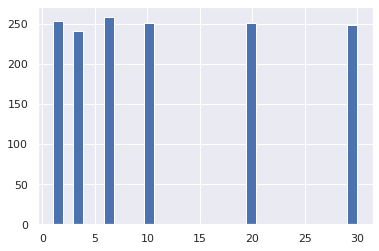

In [10]:
plt.hist(reg_pred_publ, bins=30)
plt.show()

In [11]:
reg_pred_priv = reg.predict(df_private[feat_list_train].values)

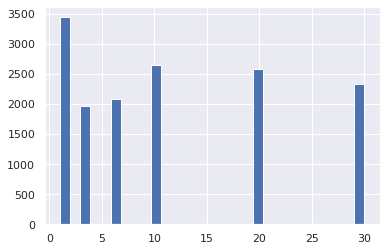

In [12]:
plt.hist(reg_pred_priv, bins=30)
plt.show()

In [13]:
reg_pred = np.append(reg_pred_publ, reg_pred_priv)

#### classification

In [14]:
df['event_class'].values

array(['NR', 'NR', 'NR', ..., 'ER', 'ER', 'ER'], dtype=object)

In [15]:
y_train_classes = np.array([df['event_class'].values[i] == 'ER' for i in range(len(df['event_class'].values))], dtype=np.int) # ER->1 NR->0

In [16]:
sc = cross_validate(RandomForestClassifier(random_state=10, max_depth=None, n_estimators=100), df[feat_list_train].values, y_train_classes, scoring='roc_auc', cv=5)
print('best model score:' + ' feat-s : {:.4f} +- {:.4f}'.format(np.mean(sc['test_score']), np.std(sc['test_score'])))

best model score: feat-s : 0.9959 +- 0.0004


In [17]:
RFT = RandomForestClassifier(random_state=10, max_depth=None, n_estimators=100).fit(df[feat_list_train].values, y_train_classes)
cl_pred_publ = RFT.predict(df_public[feat_list_train].values)

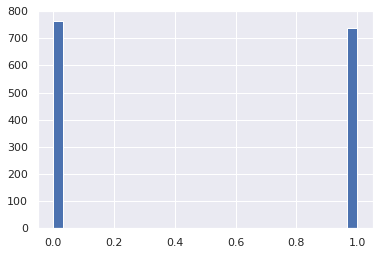

In [18]:
plt.hist(cl_pred_publ, bins=30)
plt.show()

In [19]:
cl_pred_priv = RFT.predict(df_private[feat_list_train].values)

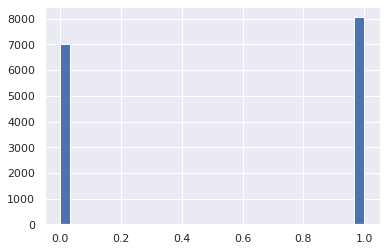

In [20]:
plt.hist(cl_pred_priv, bins=30)
plt.show()

In [21]:
cl_pred = np.append(cl_pred_publ, cl_pred_priv)

#### submission

In [22]:
im_names = np.append(df_public['image_name'].values, df_private['image_name'].values)
im_names_publ = df_public['image_name'].values

In [23]:
generate_submission(cl_pred_publ, reg_pred_publ, im_names_publ, 'solid_solution_for_public')
# generate_submission(cl_pred, reg_pred, im_names, 'solid_solution')

In [24]:
# pd.read_csv('solid_solution_for_public.csv')

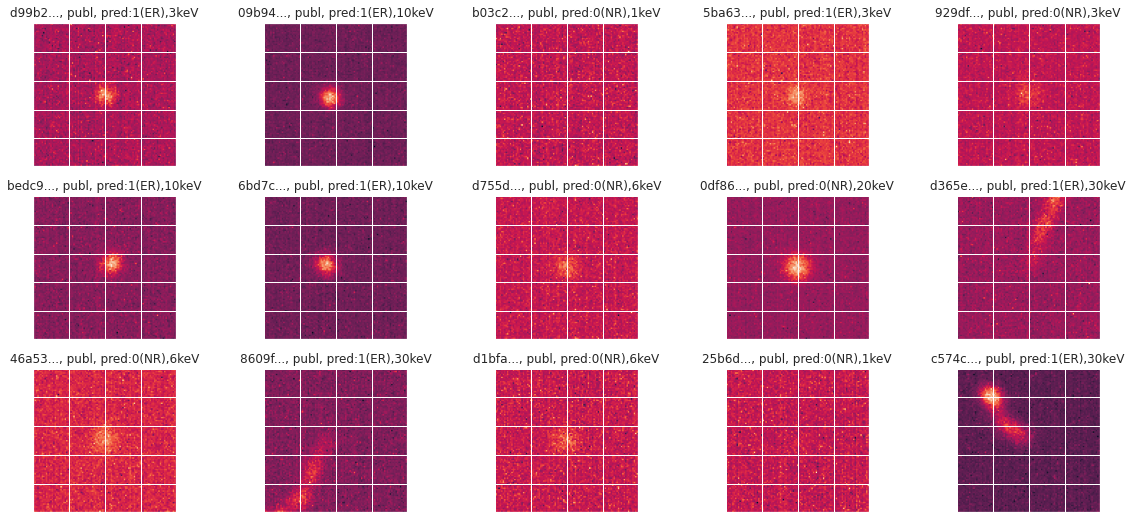

In [25]:
tmp = plot_images('../../idao_dataset/', 'solid_solution_for_public.csv')